# 溶解度予測
## ECFP -> ニューラルネットワーク

In [2]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.utils.data
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # 最適化アルゴリズム実装のためのライブラリ

In [5]:
df = pd.read_csv("delaney-processed.csv")

In [6]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [7]:
def f(smiles):
    mol = Chem.MolFromSmiles(smiles)
    bit_morgan = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bit_morgan)
    return list(fp)

In [8]:
df["smile"] = df["smiles"].map(f)
df.rename(columns={"ESOL predicted log solubility in mols per litre": 'target'},inplace=True)
df["target"] = - df["target"]

In [9]:
df1 = df[['target','smile']]
df1.tail()

,target,smile
1123,2.608,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1124,0.908,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1125,3.323,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1126,2.245,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1127,4.320,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

X = df1["smile"].values.tolist()
y = df1["target"].values.tolist()
clf = MLPRegressor(hidden_layer_sizes = (128,128), solver = "sgd")

In [11]:
x = sum(y)/len(y)
x

2.988192375886524

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf.fit(X_train, y_train)
correct = y_test
predict = clf.predict(X_test)
ans = np.sqrt(mean_squared_error(y_test, predict))
print(ans)

0.8834431141092106


C:\Users\Takumi Inui\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [13]:
abc = 0
for i in y_train:
    abc += np.sqrt((i-x) ** 2)
abc

1027.530041666667

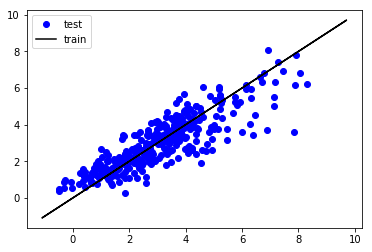

In [14]:
plt.plot(correct, predict, "bo", label="test")
plt.plot(y_train, y_train, "k",label="train")
plt.legend()
plt.show()

In [15]:
class Net(nn.Module):  # 多層ニューラルネットワークの構築
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 128)  # 一つ目の隠れ層のユニット数は512
        self.fc2 = nn.Linear(128, 128)  # 二つ目の隠れ層のユニット数は128
        self.fc3 = nn.Linear(128, 1)  # 出力層のユニット数は10


    def forward(self, x):
        x = F.relu(self.fc1(x))  # 活性化関数にはReLUを使用
        x = F.relu(self.fc2(x))  # 活性化関数にはReLUを使用
        x = self.fc3(x)
        return x

net = Net()

In [16]:
train_label = torch.tensor(df1["target"]).float()
train_data = torch.tensor(df1["smile"]).float()

In [17]:
type(df1["smile"])

pandas.core.series.Series

In [54]:
train_tensor = torch.utils.data.TensorDataset(train_data,train_label)
train_dataset, test_dataset = torch.utils.data.random_split(train_tensor, [1000, 128])

In [55]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [56]:
criterion = nn.MSELoss()  # 学習の際、目的関数として最小二乗誤差を使用
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

In [57]:
lambda1, lambda2 = 0.5, 0.0001

In [58]:
for epoch in range(30):  # エポック数を2に設定
    total_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data  # ミニバッチの学習データを取得
        optimizer.zero_grad()  # 勾配の初期化
        # 誤差逆伝播によりネットワークのパラメータの値を更新
        outputs = net(inputs)
        loss = criterion(labels, outputs)
#        all_linear1_params = torch.cat([x.view(-1) for x in net.parameters()])
#        all_linear2_params = torch.cat([x.view(-1) for x in net.parameters()])
#        l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
#        l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)
#        loss = criterion(labels, outputs) + l2_regularization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
print('\n学習が終了しました。')

373.56498289108276
328.41282653808594
283.2703495025635
252.70025873184204
205.3877820968628
166.58023083209991
138.45989847183228
115.01351249217987
101.76621091365814
98.99380910396576
94.96437764167786
94.67296648025513
94.4176059961319
94.58668506145477
95.38460183143616
95.13635349273682
94.16533625125885
94.08969259262085
93.21318054199219
94.58675277233124
92.70225828886032
92.85312843322754
93.35386788845062
93.29314959049225
93.10941874980927
95.34335207939148
92.23775637149811
92.99487590789795
92.74298596382141
93.72749078273773

学習が終了しました。


In [59]:
correct = []  # 正答数を表す
predict = []  # テストデータの総数を表す
for data in test_loader:
    inputs, labels = data
    outputs = net(inputs)
    predicted = outputs.data.tolist()
    correct.append(labels.tolist())
    predict.append(predicted)

In [60]:
import itertools
predict = list(itertools.chain.from_iterable(predict))
correct = list(itertools.chain.from_iterable(correct))

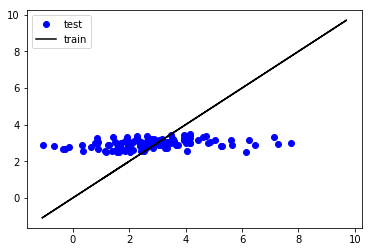

In [61]:
plt.plot(correct, predict, "bo", label="test")
plt.plot(y_train, y_train, "k",label="train")
plt.legend()
plt.show()

In [27]:
correct = []  # 正答数を表す
predict = []  # テストデータの総数を表す
for data in train_loader:
    inputs, labels = data
    outputs = net(inputs)
    predicted = outputs.data.tolist()
    correct.append(labels.tolist())
    predict.append(predicted)

In [28]:
import itertools
predict = list(itertools.chain.from_iterable(predict))
correct = list(itertools.chain.from_iterable(correct))

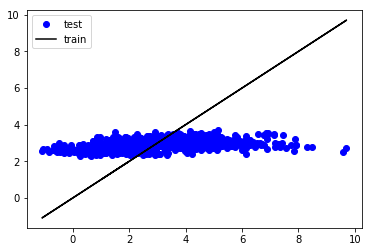

In [29]:
plt.plot(correct, predict, "bo", label="test")
plt.plot(y_train, y_train, "k",label="train")
plt.legend()
plt.show()